# Research Stay: Predictive Maintenance Experiments

## Dependencies

In [1]:
import timeit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso, LassoLars
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from loss import phmap_loss


## Data Fetching

We'll read the data already processed by other steps in the repo

In [2]:
X = pd.read_csv('data/phmap_dataset.csv')
y = pd.read_csv('data/ruls.csv')

## Flight History Overview

Analyze the whole life of a plane through the lens of one of the statistical descriptors provided

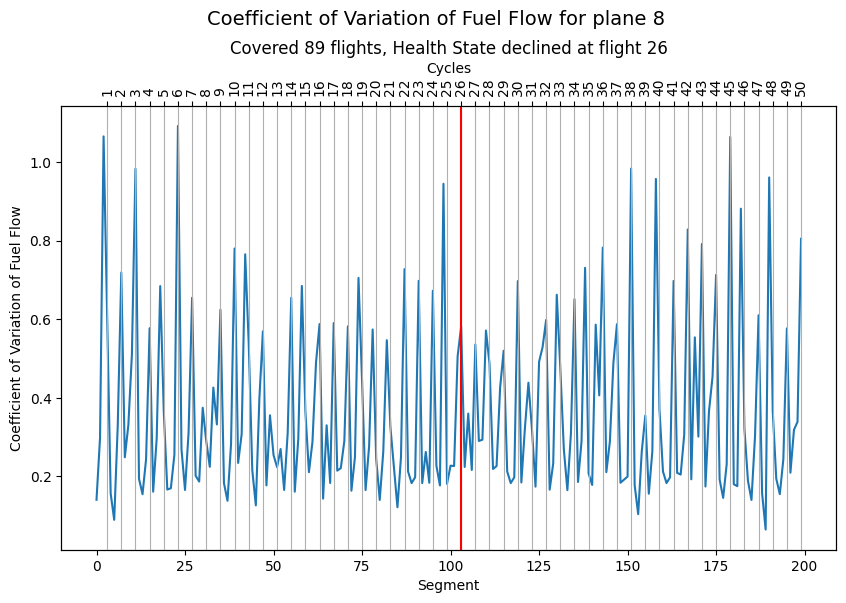

In [3]:
bks = 3
temperatures = ['T24', 'T30', 'T48', 'T50']
pressures = ['P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50']
motor_vars = ['Nf', 'Nc', 'Wf']
environment = ['alt', 'Mach', 'TRA', 'T2']

unit = 'DS01-005_8'
data = X[X['unit_names'] == unit]
tot_life = len(data)
label = 'Wf_var_coeff'
pretty_label = 'Coefficient of Variation of Fuel Flow'

data = data.iloc[:50, :]
var_cols = [c for c in data.columns if label in c]
damaged = int(data[data['hs'] == 0].head(1)['n_flight'].item())
vals = data[var_cols].values.flatten()
x = np.arange(0, len(vals))


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, vals)
ax.set_ylabel(pretty_label)
ax.set_xlabel('Segment')

# Secondary axis
ax2 = ax.twiny()
step = bks
secondary_ticks = x[::bks + 1]

# Calculate the offset to align the zeros
offset = x[bks] - secondary_ticks[0]

# Set the tick positions and labels for the secondary x-axis
ax2.set_xticks(secondary_ticks)
ax2.set_xticklabels([f'{i+1}' for i in range(len(secondary_ticks))], rotation=90)
ax2.axvline(x=secondary_ticks[damaged - 1], color='red')
ax2.set_xlabel('Cycles')

# Adjust the limits of the secondary x-axis to match the main x-axis
ax2.set_xlim(ax.get_xlim()[0] - offset, ax.get_xlim()[1] - offset)

plt.suptitle(f"{pretty_label} for plane {unit.split('_')[-1]}", y=1.01, fontsize=14)
ax.set_title(f'Covered {tot_life} flights, Health State declined at flight {damaged}')
plt.grid()
plt.subplots_adjust(top=0.85)
plt.savefig(f'img/{unit}_{label}.png',
            dpi=300,
            bbox_inches='tight')
plt.show()

## Model Selection

Here we test a suite of easy to use (and learn) ML models on a preprocessed dataset via PCA; I initially observed that applying PCA (without scaling) improved performance.

In [4]:
col_names = X.drop(['unit_names', 'hs'], axis=1).columns
X_train, X_test, y_train, y_test = train_test_split(X.drop(['unit_names', 'hs'], axis=1),
                                                    y.values.flatten(),
                                                    test_size=0.2,
                                                    random_state=7501)
trans = PCA()
X_train_proc = trans.fit_transform(X_train)
X_test_proc = trans.transform(X_test)

In [5]:
models = {
    'dummy_regressor':
        {'model': DummyRegressor(), 'params': {}},
    'linear_regression':
        {'model': LinearRegression(), 'params': {}},
    'ridge':
        {'model': Ridge(), 'params': {}},
    'elastic_net':
        {'model': ElasticNet(), 'params': {}},
    'lasso':
        {'model': Lasso(), 'params': {}},
    'lasso_lars':
        {'model': LassoLars(), 'params': {}},
    'random_forest':
        {'model': RandomForestRegressor(), 'params': {}},
    'xgb':
        {'model': XGBRegressor(), 'params': {}},
    'lgbm':
        {'model': LGBMRegressor(), 'params': {}},
    'catboost':
        {'model': CatBoostRegressor(), 'params': {'verbose': False}},
    'svm':
        {'model': SVR(), 'params': {}},
    'decision_tree':
        {'model': DecisionTreeRegressor(), 'params': {}}
    }

As a sanity check, one can see how many Principal Components are needed to hold a certain percentage of the total variance in the dataset; however filtering the dataset by these columns has a negative effect on overall model performance, as per seen below.

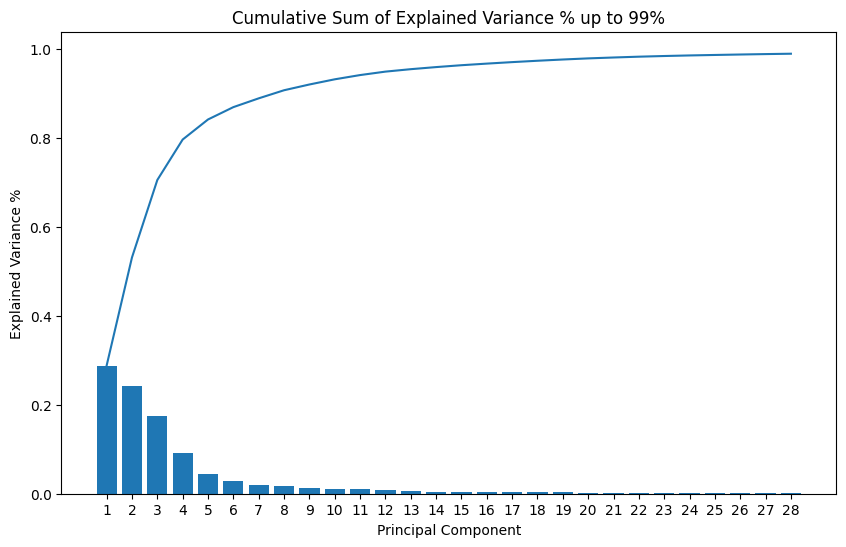

In [6]:
threshold = 0.99
variance_ratio = trans.explained_variance_ratio_
cum_variance = np.cumsum(variance_ratio)
cum_plot = cum_variance[cum_variance <= threshold]
labels = [f'{i}' for i in range(1, len(cum_plot) + 1)]
plt.figure(figsize=(10, 6))
plt.bar(labels, variance_ratio[cum_variance <= threshold])
plt.plot(cum_plot)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance %')
plt.title(f'Cumulative Sum of Explained Variance % up to {threshold:.0%}')
plt.savefig(f'img/pca_99_untransformed.png',
            dpi=300,
            bbox_inches='tight')
plt.show()


In [7]:
res_dfs = []

for model_name, model_parms in models.items():
    regressor = model_parms['model']
    start = timeit.default_timer()
    regressor.fit(X=X_train,
              y=y_train,
              **model_parms['params'])
    fit_time = timeit.default_timer() - start

    results = {'model_name': model_name,
               'train_loss': phmap_loss(y_train, regressor.predict(X_train)),
               'test_loss': phmap_loss(y_test, regressor.predict(X_test)),
               'train_r2': regressor.score(X_train, y_train),
               'test_r2': regressor.score(X_test, y_test),
               'train_rmse': mean_squared_error(y_train, regressor.predict(X_train), squared=False),
               'test_rmse': mean_squared_error(y_test, regressor.predict(X_test), squared=False),
               'fit_time': fit_time
               }

    res_dfs.append(results)

res_dfs = pd.DataFrame.from_dict(res_dfs)
res_dfs = res_dfs.sort_values(by='test_loss').round(3)
res_dfs.to_csv('data/baseline_model_comparison.csv')
res_dfs

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196216
[LightGBM] [Info] Number of data points in the train set: 5978, number of used features: 794
[LightGBM] [Info] Start training from score 38.172633


,model_name,train_loss,test_loss,train_r2,test_r2,train_rmse,test_rmse,fit_time
9,catboost,4.426,6.319,0.888,0.794,7.919,11.037,27.665
7,xgb,3.069,6.428,0.944,0.788,5.593,11.188,6.404
8,lgbm,4.362,6.484,0.891,0.784,7.814,11.285,1.881
6,random_forest,2.323,6.693,0.968,0.773,4.264,11.571,310.103
2,ridge,6.341,6.775,0.783,0.766,11.033,11.746,0.086
5,lasso_lars,6.807,6.920,0.754,0.757,11.755,11.974,0.085
4,lasso,6.807,6.920,0.754,0.757,11.755,11.974,0.130
3,elastic_net,6.863,6.972,0.750,0.754,11.835,12.048,0.270
10,svm,6.869,7.110,0.748,0.745,11.882,12.282,12.760
11,decision_tree,0.000,9.336,1.000,0.621,0.000,14.967,4.780


## PCA Effect comparison

In [8]:
configurations = {
    'Raw': Pipeline(steps=[('xgb', XGBRegressor(device='gpu'))]),
    'PCA_all': Pipeline(steps=[('pca', PCA()), ('xgb', XGBRegressor(device='gpu'))]),
    'PCA_variance': Pipeline(steps=[('pca', PCA(n_components=0.99)),
                                ('xgb', XGBRegressor(device='gpu'))]),
    'PCA_scaled_all': Pipeline(steps=[('scaler', StandardScaler()),
                                      ('pca', PCA()),
                                      ('xgb', XGBRegressor(device='gpu'))]),
    'PCA_scaled_variance': Pipeline(steps=[('scaler', StandardScaler()),
                                           ('pca', PCA(n_components=0.99)),
                                           ('xgb', XGBRegressor(device='gpu'))])
    }

results = {}
for config, pipe in configurations.items():

    pipe.fit(X_train, y_train)
    results[config] = phmap_loss(y_test, pipe.predict(X_test))

pd.Series(results)

/home/mona/college/pdm/.venv/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [16:38:23] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Raw                    6.404946
PCA_all                5.887885
PCA_variance           7.113288
PCA_scaled_all         6.754027
PCA_scaled_variance    7.632550
dtype: float64